## Setup

Downloading libraries and imports same as before. We'll be hiding those cells.

In [119]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
    !pip install -U fastai

from fastkaggle import *

Ensure fastkaggle is installed and imported for seamless Kaggle workflows.s available.

In [120]:
try: import timm
except ModuleNotFoundError:
    !pip install "timm>=0.6.2.dev0"

Ensure `timm` library is installed for PyTorch image models; install if missing.

In [121]:
from fastai.vision.all import *
from fastai.vision.all import *
import pandas as pd
import torch

Import all functions and classes from the `fastai.vision` module for deep learning tasks in computer vision.

In [122]:
comp = 'noaa-right-whale-recognition'
data_dir = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
imgs_dir = untar_dir(data_dir/'imgs.zip', Path('imgs'))

This code prepares the environment by downloading the competition data and extracting image files, while also ensuring that required libraries like fastai and timm are installed for working with deep learning models.








In [123]:
def plot_sizes(image_sizes, max_n=3000):
    sizes = parallel(image_size, image_files[:max_n], progress=progress_bar)
    
    widths, heights = zip(*sizes)
    min_x = min(widths + heights)
    max_x = max(widths + heights)
    plt.hist(widths, label='width', range=(min_x, max_x))
    plt.hist(heights, label='height', range=(min_x, max_x))
    plt.legend();

This function computes and visualizes the distribution of image widths and heights to understand their size variations. It uses parallel processing to speed up the dimension extraction and ensures both histograms are plotted with the same range for consistency.

In [124]:
image_files = get_image_files(imgs_dir)

This line helps gather the image data from the extracted folder (imgs_dir) so it can be further processed, such as for analyzing dimensions, training machine learning models, or visualizing data distributions.

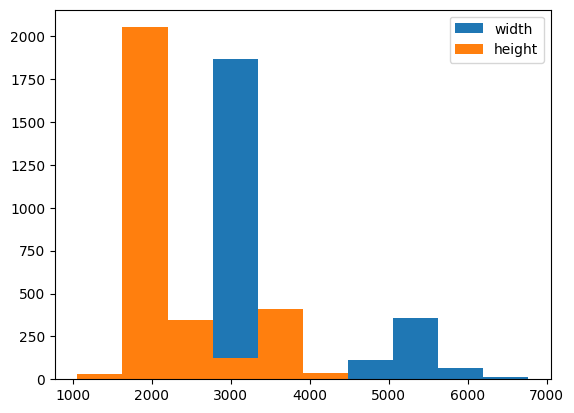

In [125]:
plot_sizes(image_files)

In the plot above we can see that majority of images are about `3000x2000`. For our first model we would like to try something around `224`. Opening these big images and downsizing by this much will bottleneck the training pipeline (you will notice the GPU will be at 0% usage for long periods).

Let's resize all images to 480 and save them to disk, fastai already provides a handy function for doing this.

In [126]:
if not Path('imgs_480max').exists():
    resize_images(imgs_dir, dest='imgs_480max', max_size=480, progress=progress_bar)

This code ensures that images are resized (if not already done) to make them uniform with a maximum size of 480 pixels, which can help optimize model training and improve memory usage. The resized images are saved to a new folder ('imgs_480max') for further use.

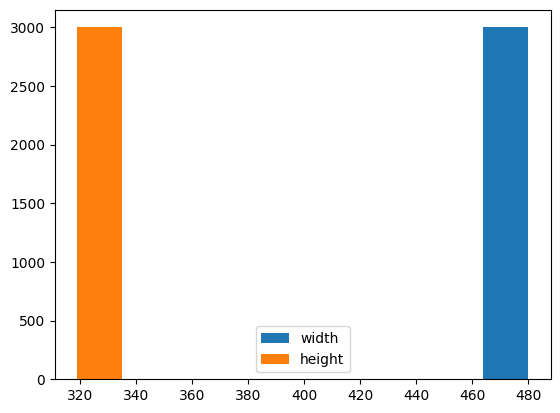

In [127]:
image_files = get_image_files('imgs_480max')
plot_sizes(image_files)

Together, these lines ensure that the image files from the resized directory are processed and visualized, allowing you to assess the dimensions of the resized images, confirming that they meet the desired size criteria and facilitating further analysis or model training.

## Data Pipeline

In [128]:
targs_df = pd.read_csv(data_dir/'train.csv')
targs_df = targs_df[targs_df['Image']!='w_7489.jpg']
items = targs_df['Image']

Reads the train.csv file into a DataFrame, excludes the row for the image 'w_7489.jpg', and extracts the remaining image names into the items variable.

In [129]:
def get_image_path(name):
    return Path('imgs_480max')/name


Defines a function `get_image_path(name)` that constructs and returns the file path for an image in the `'imgs_480max'` directory based on the provided image name.

In [130]:
def get_label(name):
    return targs_df[targs_df['Image']==name]['whaleID'].item()

Defines a function get_label(name) that retrieves and returns the corresponding whaleID for a given image name from the targs_df DataFrame.

In [131]:
x_pipe = [get_image_path, PILImage.create]
y_pipe = [get_label, Categorize()]

Sets up processing pipelines `x_pipe` for loading images using their paths and `y_pipe` for retrieving labels and categorizing them.

In [132]:
# # make sure at least one of each whale is in training set, then randomly split
# must_train_whales = targs_df.groupby('whaleID').first()['Image']
# # some magic from [here](https://stackoverflow.com/questions/49823963/get-index-of-one-series-into-another-in-pandas)
# must_train_ids = pd.Series(targs_df['Image'].index, index=targs_df['Image']).get(must_train_whales)
# must_train_ids = set(must_train_ids)

# train_ids, valid_ids = RandomSplitter(seed=42)(items)
# print(f"Before: train_ids={len(train_ids)}, valid_ids={len(valid_ids)}")
# train_ids = L(set(train_ids).union(must_train_ids))
# valid_ids = L(set(valid_ids) - must_train_ids)
# print(f"After: train_ids={len(train_ids)}, valid_ids={len(valid_ids)}")
# splits = (train_ids, valid_ids)
must_train_whales = targs_df.groupby('whaleID').first()['Image']
must_train_ids = pd.Series(targs_df['Image'].index, index=targs_df['Image']).get(must_train_whales)
must_train_ids = set(must_train_ids)

train_ids, valid_ids = RandomSplitter(seed=42)(items)
train_ids = L(set(train_ids).union(must_train_ids))
valid_ids = L(set(valid_ids) - must_train_ids)
splits = (train_ids, valid_ids)


This code ensures that at least one image of each whale species is included in the training set while randomly splitting the remaining images into training and validation sets. It prints the counts of images before and after the adjustments to confirm that the requirements are met.

In [133]:
dss = Datasets(items, [x_pipe, y_pipe], splits=splits)

Creates a Datasets object dss using the specified items, processing pipelines (x_pipe for images and y_pipe for labels), and the defined splits for training and validation data.

<Axes: title={'center': 'whale_82548'}>

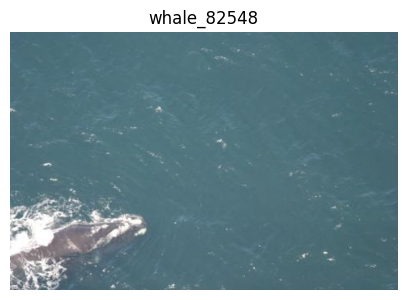

In [134]:
dss.show(dss[76])

Displays the 76th item in the Datasets object dss, showing the processed image and its corresponding label.

In [135]:
after_item = [ToTensor(), Resize((320, 480))]
after_batch = [IntToFloatTensor(), *aug_transforms(size=(224, 336))]

dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

Prepares data loaders dls from the Datasets object dss, applying specified transformations (after_item for individual items and after_batch for batches) with a batch size of 32.

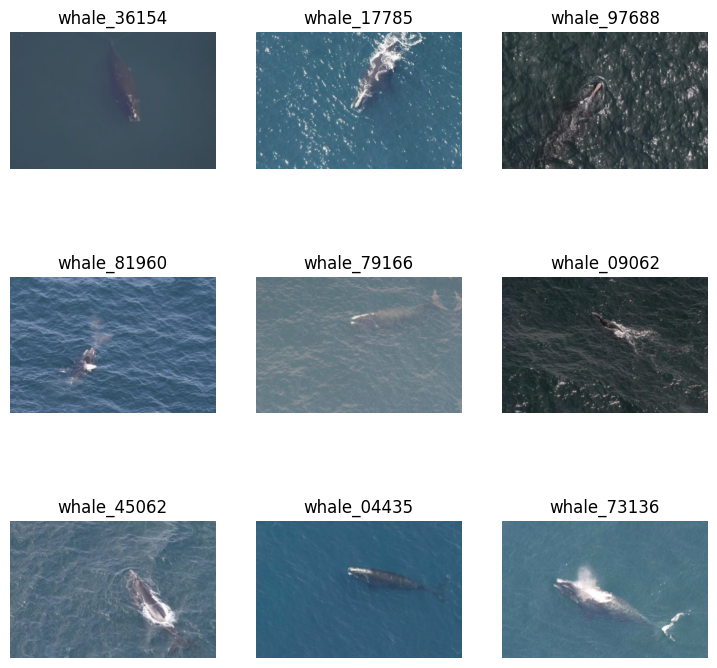

In [136]:
dls.show_batch()

## Training

No new magic happening here, again refer to the previous blog post for a detailed explanation.

In [137]:
metrics = [error_rate]

Defines a list metrics containing the error_rate function to evaluate the model's performance during training or validation.

In [138]:
pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


Installs the huggingface_hub library, which provides tools for accessing and sharing models and datasets on the Hugging Face Hub.

In [139]:
learn = vision_learner(dls, 'resnet26d', metrics=metrics, pretrained=True).to_fp16()

Creates a vision_learner object learn with a ResNet26D architecture using the specified data loaders dls, sets the evaluation metrics, and enables half-precision training with to_fp16().

/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0014454397605732083)

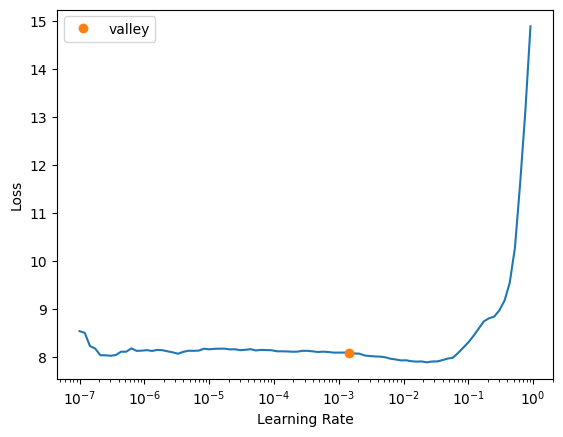

In [140]:
learn.lr_find()

Runs the learning rate finder for the learn object, which helps identify the optimal learning rate for training the model by plotting the loss against different learning rates.

In [141]:
learn.fine_tune(10, 0.002)

epoch,train_loss,valid_loss,error_rate,time
0,7.386294,6.217118,0.964417,00:20


epoch,train_loss,valid_loss,error_rate,time
0,6.091512,5.755741,0.936196,00:24
1,5.784817,5.653408,0.920245,00:23
2,5.548572,5.497794,0.909202,00:23
3,5.065949,5.327881,0.895706,00:23
4,4.651348,5.237728,0.874847,00:23
5,4.171464,5.116489,0.867485,00:23
6,3.763411,5.085211,0.851534,00:23
7,3.417623,4.991318,0.844172,00:23
8,3.160665,4.958556,0.838037,00:23
9,3.038608,4.967730,0.830675,00:23


Fine-tunes the model using the learn object for 10 epochs with a maximum learning rate of 0.002, adapting the pre-trained weights to the new dataset.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

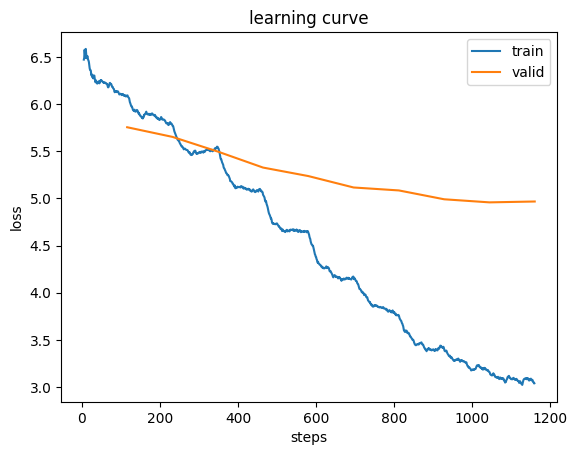

In [142]:
learn.recorder.plot_loss()

Plots the training and validation loss curves from the learn object’s recorder, visualizing the model's performance over the training epochs.

## Inference

Same function as before, just copy-pasta.

In [143]:
def submit(learn):
    test_df = pd.read_csv(data_dir / 'sample_submission.csv')
    test_dl = learn.dls.test_dl(test_df['Image'])
    
    preds, targs = learn.get_preds(dl=test_dl)
    
    df = pd.DataFrame(preds.numpy(), columns=learn.dls.vocab)
    df["Image"] = test_df['Image']
    
    preds_path = "submission.csv"
    df.to_csv(preds_path, index=False)
    
    if not iskaggle:
        from kaggle import api
        api.competition_submit_cli(preds_path, "initial submission", comp)

Testing model: hf_hub:timm/tf_efficientnet_b0.aa_in1k


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.969256,6.047029,0.014724,0.985276,00:24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.237319,5.396734,0.076074,0.923926,00:24
1,4.672815,5.197305,0.103067,0.896933,00:24
2,3.622054,4.859662,0.184049,0.815951,00:24
3,2.378208,4.664129,0.236810,0.763190,00:24
4,1.604615,4.662547,0.246626,0.753374,00:24


Testing model: hf_hub:timm/convnext_base.fb_in22k_ft_in1k


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,6.060231,6.011624,0.007362,0.992638,01:11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.962320,5.975073,0.006135,0.993865,01:11
1,5.970337,5.974387,0.011043,0.988957,01:10
2,5.942602,5.944202,0.006135,0.993865,01:10
3,5.917715,5.910517,0.011043,0.988957,01:10
4,5.854908,5.903986,0.012270,0.987730,01:10


Model: hf_hub:timm/tf_efficientnet_b0.aa_in1k
Accuracy: 0.2466
Error Rate: 0.7534
---
Model: hf_hub:timm/convnext_base.fb_in22k_ft_in1k
Accuracy: 0.0123
Error Rate: 0.9877
---
Loss plot for hf_hub:timm/tf_efficientnet_b0.aa_in1k
Loss plot for hf_hub:timm/convnext_base.fb_in22k_ft_in1k


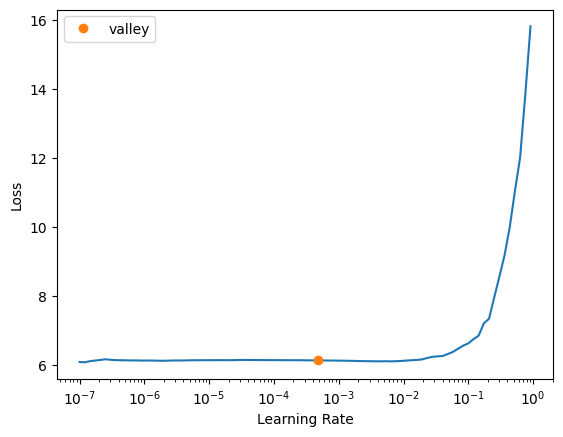

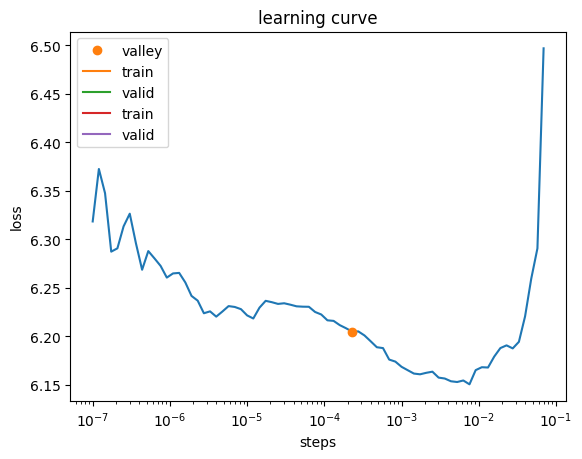

In [144]:
from fastai.vision.all import *
import timm

# Define the models you want to test
timm_models = [
    "hf_hub:timm/tf_efficientnet_b0.aa_in1k",
    "hf_hub:timm/convnext_base.fb_in22k_ft_in1k"
]

# Dictionary to store learners and their results
learners = {}

# Set metrics for comparison
metrics = [accuracy, error_rate]

for model_name in timm_models:
    print(f"Testing model: {model_name}")
    
    # Create the model with timm
    model = timm.create_model(model_name, pretrained=True, num_classes=dls.c)
    
    # Use `Learner` to initialize a learner with the custom model
    learn = Learner(dls, model, metrics=metrics).to_fp16()
    
    # Find optimal learning rate
    learn.lr_find()
    
    # Fine-tune the model
    learn.fine_tune(5, 0.002)
    
    # Save learner and metrics
    learners[model_name] = {
        'learner': learn,
        'metrics': learn.validate()
    }

# Compare results for each model
for model_name, data in learners.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {data['metrics'][1]:.4f}")
    print(f"Error Rate: {data['metrics'][2]:.4f}")
    print('---')

# Optionally, plot the loss curves for each model
for model_name, data in learners.items():
    print(f"Loss plot for {model_name}")
    data['learner'].recorder.plot_loss()


In [145]:
submit(learn)

/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Now we get a score of 4.54! A massive improvement compared to our last score of `30.29923`, and finally better than random guessing at ` 6.10255`!

Indeed this notebook should have been the first one in the series. It was much easier to produce than the last one and provides a decent baseline to start improving.

For our next steps, we can dive deeper into what transforms we want to use, scale up the size of images by using a technique known as progressive resizing and only then start thinking of going bigger with models.